In [1]:
# %% [markdown]
# # Seattle Weather Category Prediction - Jupyter Notebook
#
# This notebook aims to predict the weather category (e.g., sun, rain, snow)
# based on other meteorological features. It follows a structure similar to
# the provided Kaggle example, using Gaussian Naive Bayes.
#
# Steps:
# 1. Load and Explore Data
# 2. Visualize Data (similar to Kaggle example)
# 3. Preprocess Data (Label Encoding for target)
# 4. Train a Gaussian Naive Bayes Classifier
# 5. Evaluate the Classifier
# 6. Save the Model and Label Encoder for Flask App

# %% [markdown]
# ## 1. Setup and Load Data

# %%
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io # To load CSV from string in this environment

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib


In [2]:
# Display plots inline
%matplotlib inline
# Set some display options for Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [3]:
# %%
# --- Load the dataset ---
# In a real scenario, you would use:
file_path = 'seattle-weather.csv'
df = pd.read_csv(file_path)

In [4]:
# df = pd.read_csv(io.StringIO(csv_data))

print("Dataset loaded successfully:")
df.head()

Dataset loaded successfully:


,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [5]:
# %% [markdown]
# ## 2. Initial Data Exploration & Visualization (Kaggle Style)

# %%
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [6]:
# %%
print("\nStatistical Summary:")
print(df.describe())


Statistical Summary:
       precipitation     temp_max     temp_min         wind
count    1461.000000  1461.000000  1461.000000  1461.000000
mean        3.029432    16.439083     8.234771     3.241136
std         6.680194     7.349758     5.023004     1.437825
min         0.000000    -1.600000    -7.100000     0.400000
25%         0.000000    10.600000     4.400000     2.200000
50%         0.000000    15.600000     8.300000     3.000000
75%         2.800000    22.200000    12.200000     4.000000
max        55.900000    35.600000    18.300000     9.500000


In [7]:
# %%
print("\nMissing Values Check:")
print(df.isnull().sum()) # Should be 0 for this dataset
print(f"\nAny NA values present: {df.isna().sum().any()}")

# %%
print("\nDuplicate Rows Check:")
print(f"Number of duplicated rows: {df.duplicated().sum()}") # Should be 0 for this dataset

# %%
print("\nDay with Minimum temp_min:")
print(df[df['temp_min']==min(df.temp_min)])

# %%
print("\nDay with Maximum temp_max:")
print(df[df['temp_max']==max(df.temp_max)])



Missing Values Check:
date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

Any NA values present: False

Duplicate Rows Check:
Number of duplicated rows: 0

Day with Minimum temp_min:
           date  precipitation  temp_max  temp_min  wind weather
706  2013-12-07            0.0       0.0      -7.1   3.1     sun

Day with Maximum temp_max:
           date  precipitation  temp_max  temp_min  wind weather
953  2014-08-11            0.5      35.6      17.8   2.6    rain


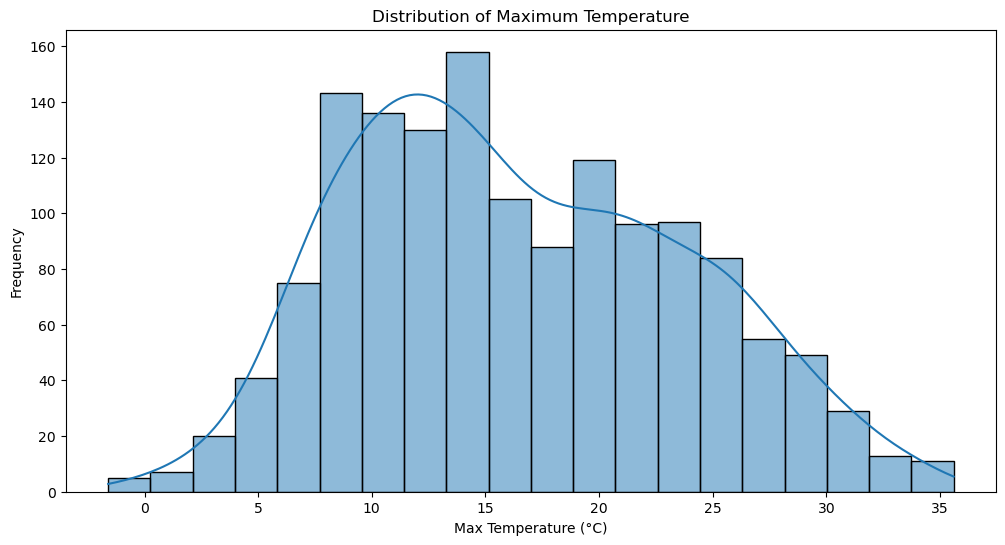

In [8]:
# %%
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='temp_max', bins=20, kde=True)
plt.title('Distribution of Maximum Temperature')
plt.xlabel('Max Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

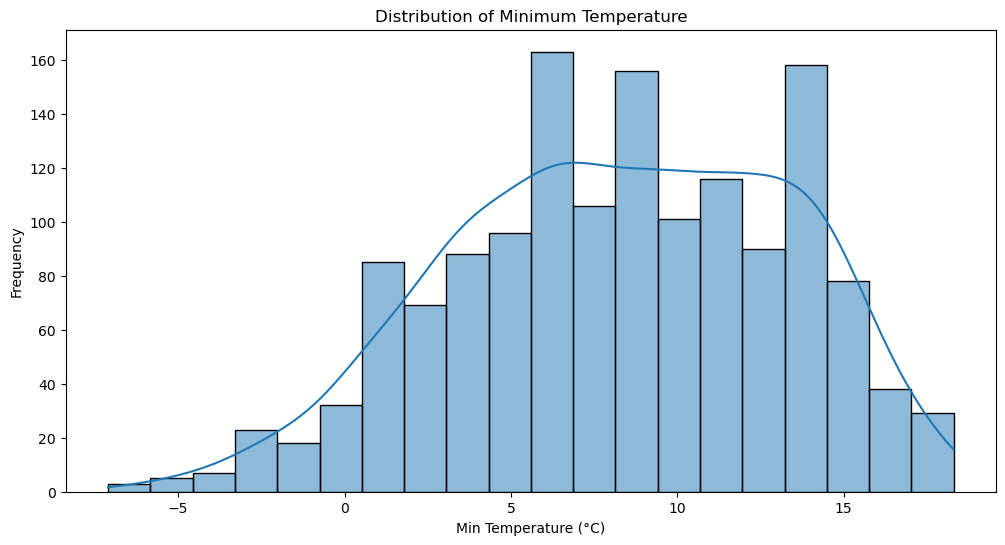

In [9]:
# %%
plt.figure(figsize=(12,6))
sns.histplot(data=df, x='temp_min', bins=20, kde=True)
plt.title('Distribution of Minimum Temperature')
plt.xlabel('Min Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

In [10]:
# %% [markdown]
# ### FacetGrid Visualizations (Month vs. Weather Variables by Year)
# First, convert 'date' to datetime and extract 'year' and 'month'.

# %%
df_vis = df.copy() # Create a copy for visualization to keep original df clean for now
df_vis['date'] = pd.to_datetime(df_vis['date'])
df_vis['year'] = df_vis['date'].dt.year
df_vis['month'] = df_vis['date'].dt.month

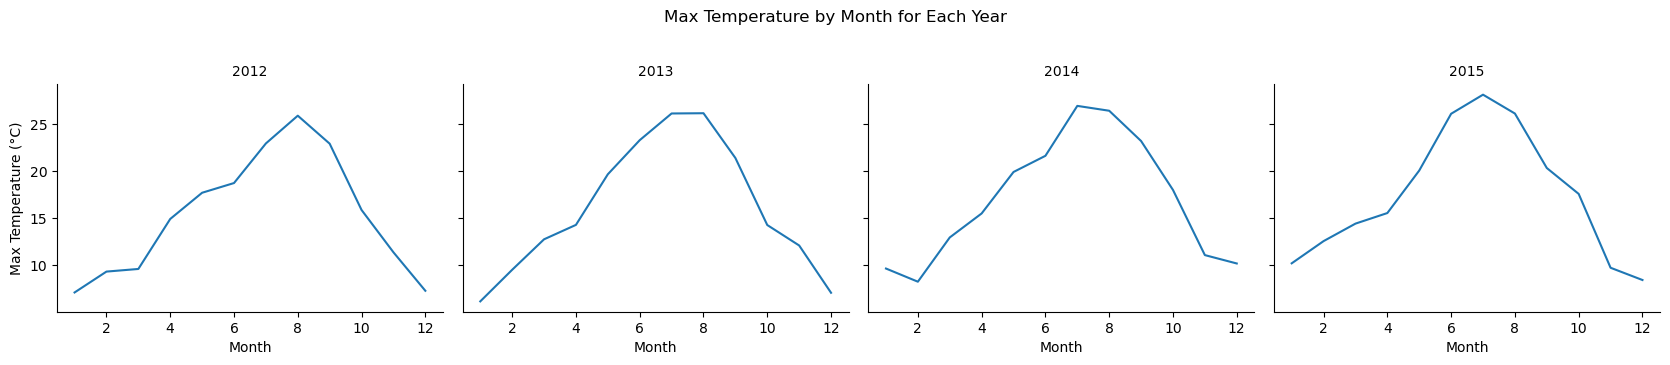

In [11]:
# %%
# Max Temperature vs. Month by Year
g = sns.FacetGrid(df_vis, col='year', col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.lineplot, 'month', 'temp_max', errorbar=None) # errorbar=None to remove confidence intervals for clarity
g.set_axis_labels('Month', 'Max Temperature (°C)')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Max Temperature by Month for Each Year', y=1.03) # Add a main title
plt.tight_layout()
plt.show()

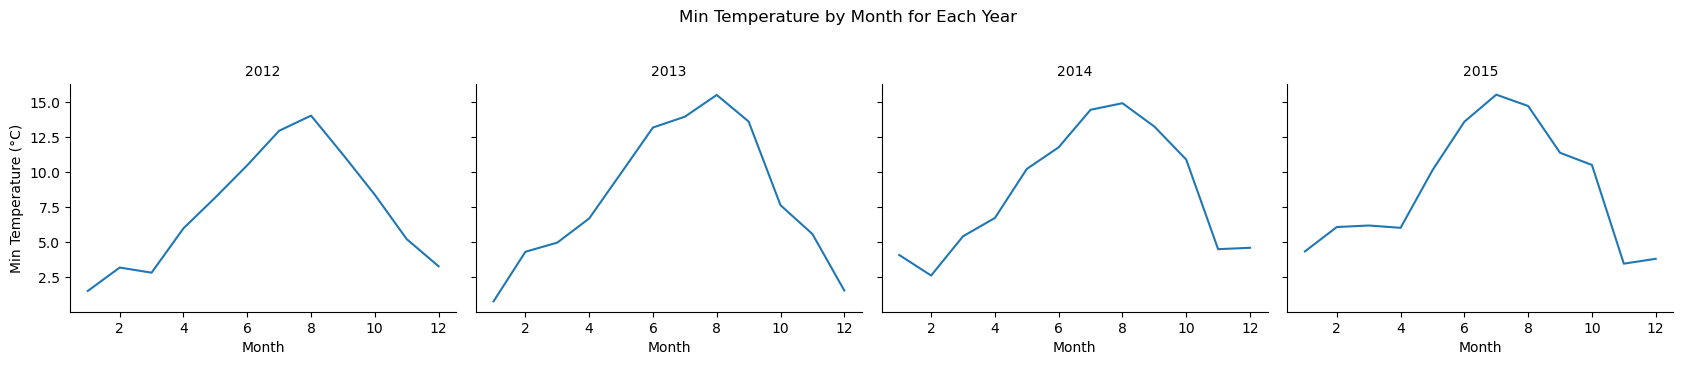

In [12]:
# %%
# Min Temperature vs. Month by Year
g = sns.FacetGrid(df_vis, col='year', col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.lineplot, 'month', 'temp_min', errorbar=None)
g.set_axis_labels('Month', 'Min Temperature (°C)')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Min Temperature by Month for Each Year', y=1.03)
plt.tight_layout()
plt.show()

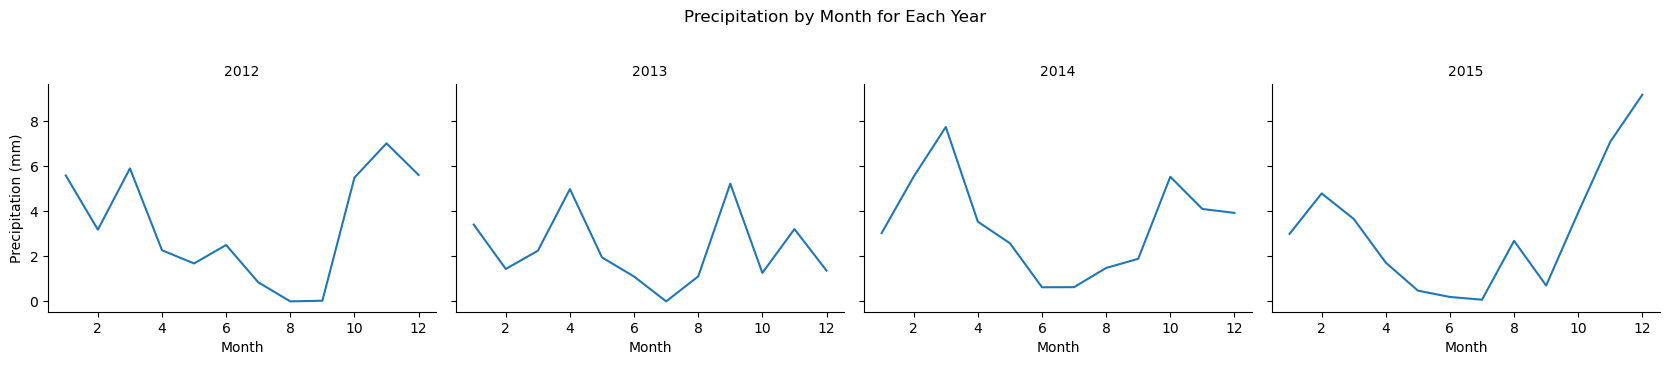

In [13]:
# %%
# Precipitation vs. Month by Year
g = sns.FacetGrid(df_vis, col='year', col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.lineplot, 'month', 'precipitation', errorbar=None) # Lineplot might be better than scatter for trends
g.set_axis_labels('Month', 'Precipitation (mm)')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Precipitation by Month for Each Year', y=1.03)
plt.tight_layout()
plt.show()

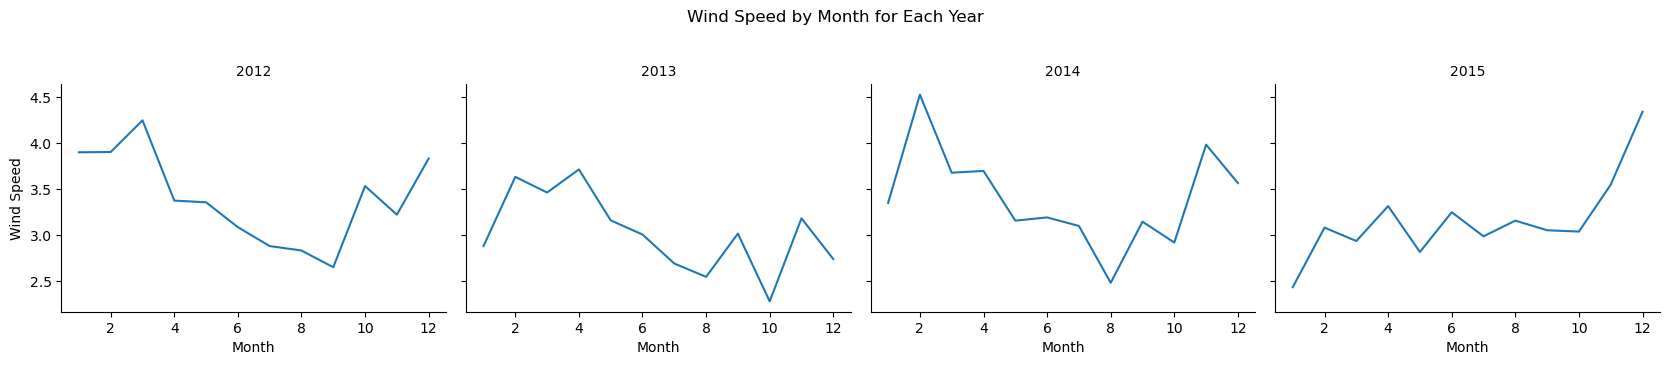

In [14]:
# %%
# Wind Speed vs. Month by Year
g = sns.FacetGrid(df_vis, col='year', col_wrap=4, height=3.5, aspect=1.2)
g.map(sns.lineplot, 'month', 'wind', errorbar=None) # Lineplot for trends
g.set_axis_labels('Month', 'Wind Speed')
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Wind Speed by Month for Each Year', y=1.03)
plt.tight_layout()
plt.show()


Weather Category Counts:
weather
rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: count, dtype: int64


C:\Users\MY\AppData\Local\Temp\ipykernel_21240\2827171873.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='weather', order=weather_counts.index, palette="viridis")


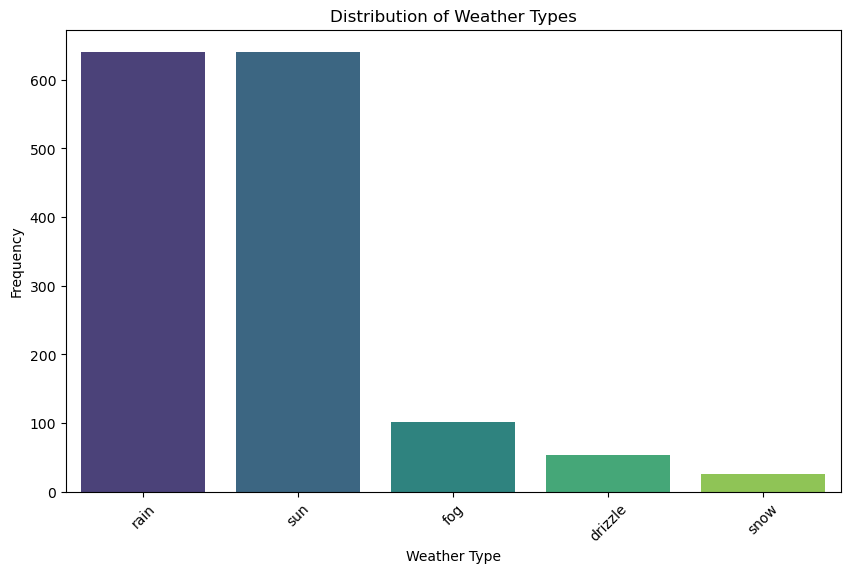

In [15]:
# %% [markdown]
# ### Weather Category Distribution

# %%
print("\nWeather Category Counts:")
weather_counts = df['weather'].value_counts()
print(weather_counts)

# %%
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='weather', order=weather_counts.index, palette="viridis")
plt.title('Distribution of Weather Types')
plt.xlabel('Weather Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

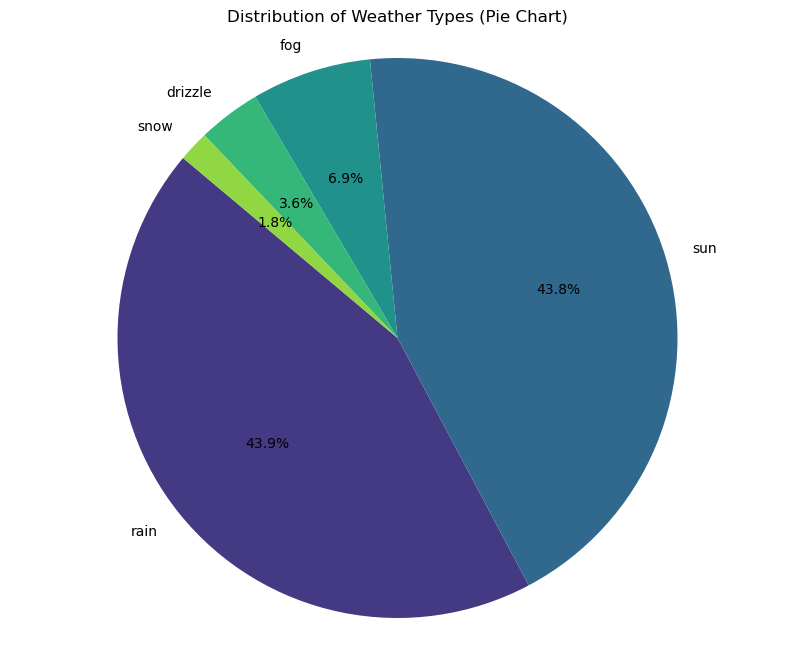

In [16]:
# %%
plt.figure(figsize=(10, 8))
plt.pie(weather_counts, labels=weather_counts.index, autopct='%1.1f%%', startangle=140,
        colors=sns.color_palette("viridis", len(weather_counts)))
plt.title('Distribution of Weather Types (Pie Chart)')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [17]:
# %% [markdown]
# ## 3. Data Preprocessing for Classification
# The Kaggle notebook drops 'year' and 'month' after visualization and does not use 'date'.
# It then label encodes 'weather' for the target variable.

# %%
# Drop the 'date' column as it won't be used directly as a feature in this specific approach.
# Note: For more advanced time-series models, date components or the date itself could be crucial.
# The Kaggle example's feature set is ['temp_min', 'temp_max', 'precipitation', 'wind'].
if 'date' in df.columns:
    df = df.drop('date', axis=1)

print("\nDataFrame columns before modeling:", df.columns.tolist())
df.head()


DataFrame columns before modeling: ['precipitation', 'temp_max', 'temp_min', 'wind', 'weather']


,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,drizzle
1,10.9,10.6,2.8,4.5,rain
2,0.8,11.7,7.2,2.3,rain
3,20.3,12.2,5.6,4.7,rain
4,1.3,8.9,2.8,6.1,rain


In [18]:
# %%
# Label Encode the target variable 'weather'
le = LabelEncoder()
df['weather_encoded'] = le.fit_transform(df['weather'])

# Display the mapping
print("\nLabel Encoding Mapping for 'weather':")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name} -> {i}")


Label Encoding Mapping for 'weather':
drizzle -> 0
fog -> 1
rain -> 2
snow -> 3
sun -> 4


In [19]:
# Save the label encoder for use in the Flask app (to decode predictions)
joblib.dump(le, 'weather_label_encoder.joblib')
print("\nSaved weather_label_encoder.joblib")

df.head()


Saved weather_label_encoder.joblib


,precipitation,temp_max,temp_min,wind,weather,weather_encoded
0,0.0,12.8,5.0,4.7,drizzle,0
1,10.9,10.6,2.8,4.5,rain,2
2,0.8,11.7,7.2,2.3,rain,2
3,20.3,12.2,5.6,4.7,rain,2
4,1.3,8.9,2.8,6.1,rain,2


In [20]:
# %% [markdown]
# ## 4. Feature Selection and Train-Test Split
# Based on the Kaggle example, features are 'temp_min', 'temp_max', 'precipitation', 'wind'.
# Target is the encoded 'weather'.

# %%
X = df[['temp_min', 'temp_max', 'precipitation', 'wind']]
y = df['weather_encoded'] # Use the numerically encoded weather column


In [21]:
# Store the feature names model will be trained on (for Flask app input)
feature_names_for_model = X.columns.tolist()
joblib.dump(feature_names_for_model, 'classifier_feature_names.joblib')
print(f"Saved classifier_feature_names.joblib with features: {feature_names_for_model}")

Saved classifier_feature_names.joblib with features: ['temp_min', 'temp_max', 'precipitation', 'wind']


In [22]:
# Split data - using random split as per Kaggle example
# Note: For time-series data, a chronological split is generally better practice.
# If you want a chronological split:
# split_ratio = 0.8
# split_index = int(len(df) * split_ratio)
# X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
# y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify=y is good for imbalanced classes

print(f"\nX_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (1168, 4), y_train shape: (1168,)
X_test shape: (293, 4), y_test shape: (293,)


In [23]:
# %% [markdown]
# ## 5. Model Training (Gaussian Naive Bayes)

# %%
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

print("Gaussian Naive Bayes model trained.")

Gaussian Naive Bayes model trained.


In [24]:
# %% [markdown]
# ## 6. Model Evaluation

# %%
y_pred = nb_model.predict(X_test)
y_pred_proba = nb_model.predict_proba(X_test) # Get probabilities for each class

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
# Use le.classes_ to get original string labels for the classification report
classification_rep = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)

print(f"\nAccuracy: {accuracy:.4f}") # Increased precision for accuracy

print("\nConfusion Matrix:")


Accuracy: 0.8259

Confusion Matrix:


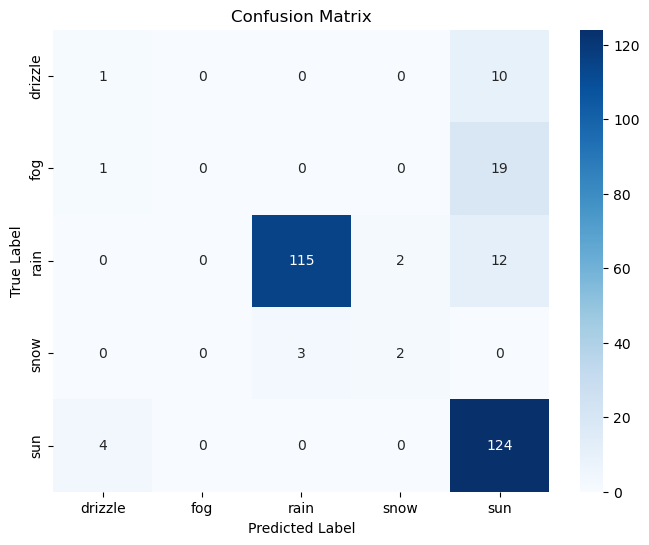


Classification Report:
              precision    recall  f1-score   support

     drizzle       0.17      0.09      0.12        11
         fog       0.00      0.00      0.00        20
        rain       0.97      0.89      0.93       129
        snow       0.50      0.40      0.44         5
         sun       0.75      0.97      0.85       128

    accuracy                           0.83       293
   macro avg       0.48      0.47      0.47       293
weighted avg       0.77      0.83      0.79       293



In [25]:
# For better visualization of confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_rep)